In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
N_TRIAL = 30000
N_ARMS = 100
N_FEATURE = 3
M = 4
np.random.seed(123)

In [3]:
Beta = np.genfromtxt('Beta.csv',delimiter=',')
X_1 = np.genfromtxt('X.csv',delimiter=',')
Y_1 = np.genfromtxt('Y.csv',delimiter=',')
E = np.genfromtxt('E.csv',delimiter=',')
# E2 = np.genfromtxt('E(100).csv',delimiter=',')

In [4]:
def make_regret(payoff, oracle):
    return np.cumsum(oracle - payoff)

def plot_regrets(results, oracle):
    [plt.plot(make_regret(payoff=x['r_payoff'], oracle=oracle), label="alpha: "+str(alpha)) for (alpha, x) in results.items()]

In [5]:
def plot_l2_norm_diff(results, true_theta, n_trial, n_arms):
    [plt.plot(make_l2_norm_diff(x['theta'], true_theta, n_trial, n_arms), label="alpha: "+str(alpha)) for (alpha, x) in results.items()]
def make_l2_norm_diff(theta, true_theta, n_trial, n_arms): #, true_choice
    diff = []
    for t in range(n_trial):
        diff_t = 0
        for arm in range(n_arms):
            diff_vec = theta[t, arm] - true_theta[arm] #true_choice[t][i]
            diff_t += np.linalg.norm(diff_vec, ord=2)
        diff.append(diff_t)
    return np.array(diff)

In [6]:
def linUCB(lda, alpha, X, Y, m):
    print("linUCB with alpha:", alpha)
    n_trial, n_arms, n_feature = X.shape
    
    # 1.Initialize object
    r_payoff = np.empty(n_trial)
    arm_choice = np.empty(shape=(n_trial, m), dtype=int)
    theta = np.empty(shape=(n_trial, n_arms, n_feature)) 
    p = np.empty(shape=(n_trial, n_arms)) 
    
    A = np.array([lda * np.diag(np.ones(shape=n_feature)) for _ in np.arange(n_arms)])
    b = np.array([np.zeros(shape=n_feature) for _ in np.arange(n_arms)])

    # 2. Algorithm
    for t in np.arange(n_trial): 
        for a in np.arange(n_arms):
            inv_A       = np.linalg.inv(A[a])
            theta[t, a] = inv_A.dot(b[a])
            p[t, a]     = theta[t, a].dot(X[t, a]) + alpha * np.sqrt(X[t, a].dot(inv_A).dot(X[t, a]))
        
        # Choose m best arms
        idx = np.argpartition(p[t], -m)[-m:]
        chosen_arms = idx[np.argsort((-p[t])[idx])] #lst
        for i in np.arange(m):
          arm_choice[t][i] = chosen_arms[i]
        
        # Update A and b
        for chosen_arm in arm_choice[t]:
          A[chosen_arm] += np.outer(X[t, chosen_arm], X[t, chosen_arm].T)
          b[chosen_arm] += Y[t, chosen_arm] * X[t, chosen_arm]
            
        r_payoff[t]   = np.sum([Y[t, choice] for choice in arm_choice[t]])
        # print('Trial:', t, '| arm selected:', chosen_arms) ##
    
    return dict(theta=theta, p=p, arm_choice = arm_choice, r_payoff=r_payoff, A=A)

In [7]:
X_1_lst = []
for T in np.arange(N_TRIAL):
  X_1t_lst = []
  for arm in np.arange(N_ARMS):
    temp = []
    temp.append(1)
    temp.append(0.001*(T+1))
    temp.append((0.001*(T+1))**2)
    X_1t_lst.append(np.array(temp))
    # np.append(X_1, X_1t)
  X_1_lst.append(np.array(X_1t_lst))
X_1 = np.array(X_1_lst)

In [8]:
oracle_lst = []
true_choice = []
for t in np.arange(N_TRIAL):
  # Find indices of M highest arms
  all_reward_t = [Y_1.T[t, arm] for arm in np.arange(N_ARMS)]
  idx = np.argpartition(all_reward_t, -M)[-M:]
  chosen_arms = idx[np.argsort((-np.array(all_reward_t))[idx])]
  # Sum of M highest rewards
  oracle_payoff_t = np.sum([Y_1.T[t, choice] for choice in chosen_arms])
  # Append to the list
  oracle_lst.append(oracle_payoff_t)
  true_choice.append(chosen_arms)
oracle_case1 = np.array(oracle_lst)

In [9]:
alpha_to_test = [0, 1, 2.5, 5, 10, 20]
# [0, 1, 2.5, 5, 10, 20]
results_dict = {alpha: linUCB(lda = 0.5, alpha = alpha, X=X_1, Y=Y_1.T, m=M)\
                for alpha in alpha_to_test}

linUCB with alpha: 0
linUCB with alpha: 1
linUCB with alpha: 2.5
linUCB with alpha: 5
linUCB with alpha: 10
linUCB with alpha: 20


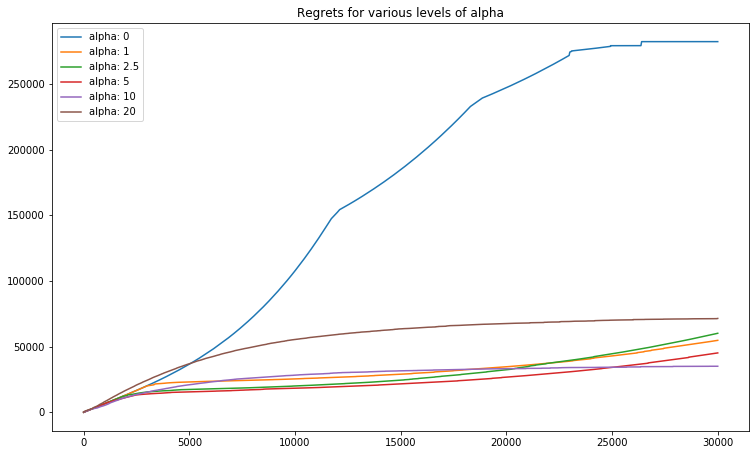

In [10]:
# Plot regrets for various levels of alpha
plt.figure(figsize=(12.5, 7.5))
plot_regrets(results_dict, oracle_case1)
plt.legend()
plt.title("Regrets for various levels of alpha")
plt.show()

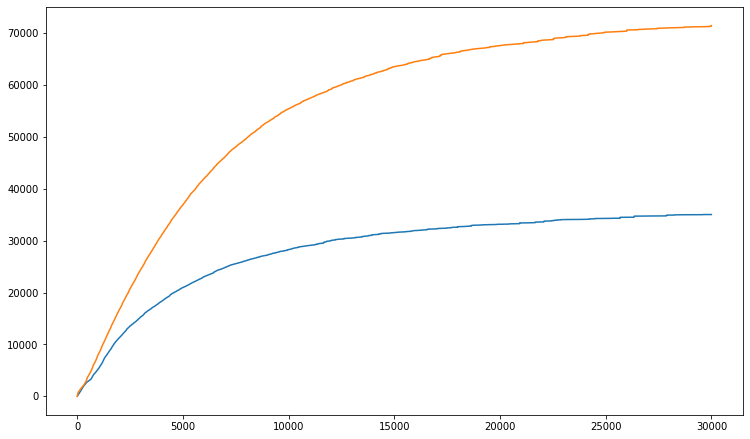

In [11]:
# Plot regrets for alpha = 10, 20
test_lst = [make_regret(payoff=x['r_payoff'], oracle=oracle_case1) for (alpha, x) in results_dict.items()]
plt.figure(figsize=(12.5, 7.5))
plt.plot(test_lst[4])
plt.plot(test_lst[5])

In [12]:
# Plot l2-difference
#True Beta
Beta_reshape = Beta.T
Beta_reshape.shape
t_l2_norm_lst = []
for i in range (N_ARMS):
    t_l2_norm_lst.append(np.linalg.norm(Beta_reshape[i], ord=2))
t_l2_norm = np.array(t_l2_norm_lst)

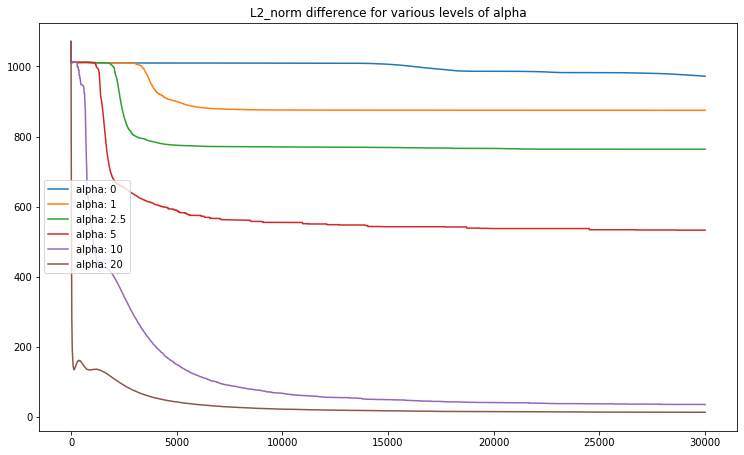

In [13]:
# Plot l2_norm difference for various levels of alpha
plt.figure(figsize=(12.5, 7.5))
plot_l2_norm_diff(results_dict, Beta_reshape, n_trial=N_TRIAL, n_arms=N_ARMS)
plt.legend()
plt.title("L2_norm difference for various levels of alpha")
plt.show()

In [14]:
dict2 = results_dict.copy()
dict2.pop(0)
dict2.pop(1)
dict2.pop(2.5)
dict2.pop(5)

{'theta': array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
 
        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 1.12675744e+01,  1.12675744e-02,  1.12675744e-05]],
 
        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.

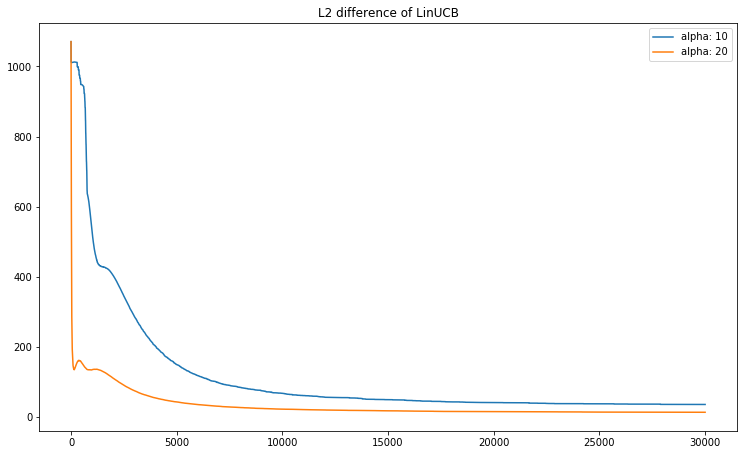

In [15]:
# Plot l2_norm difference for various levels of alpha
plt.figure(figsize=(12.5, 7.5))
plot_l2_norm_diff(dict2, Beta_reshape, n_trial=N_TRIAL, n_arms=N_ARMS)
plt.legend()
plt.title("L2 difference of LinUCB")
plt.show()

In [17]:
# export l2
test_lst2 = [make_l2_norm_diff(x['theta'], Beta_reshape, N_TRIAL, N_ARMS) for (alpha, x) in results_dict.items()]
df2 = pd.DataFrame(test_lst2[4]) #index 
df2.to_csv('LinUCB10_l2norm.csv', header=False)

# export regret data
# test_lst = [make_regret(payoff=x['r_payoff'], oracle=oracle_case1) for (alpha, x) in results_dict.items()]
# df = pd.DataFrame(test_lst[4]) #index 4 is for alpha = 10 
# df.to_csv('LinUCB_regret.csv', header=False)